In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(root)

import pandas as pd
import numpy as np
import yfinance as yf

import datetime

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Define tickers we want to track
tickers = ['SPY', 'UPRO', 'QQQ', 'TQQQ', 'MINT', 'ETHA', 'IBIT', 'IWM', 'UWM', 'IEF']

# Fetch EOD closing prices from yfinance
# Start from a reasonable date (e.g., 5 years ago) or adjust as needed
data = yf.download(
    tickers,
    start="2020-01-01",
    interval="1d",
    group_by="column"
).xs('Close', axis=1)
# Display the last few rows

[*********************100%***********************]  10 of 10 completed


<Axes: xlabel='Date'>

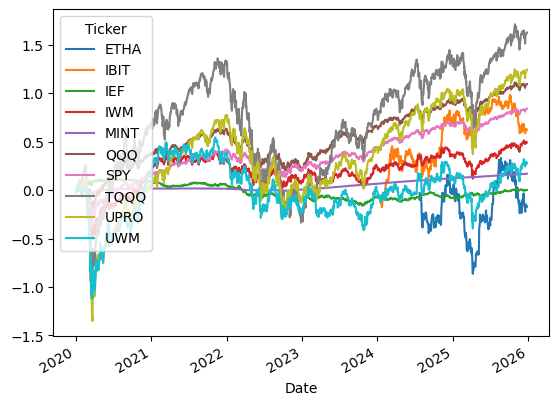

In [4]:
np.log(data).diff().dropna(how='all').cumsum().plot()

In [5]:
from fredapi import Fred

fred = Fred(api_key=os.environ['FRED_API_KEY'])
rvx = fred.get_series("RVXCLS", observation_start="2025-11-01", observation_end="2025-12-31")

In [6]:
from jobs import data_dump_job as ddd
out = ddd.fetch_price_data(ddd.INVESTABLE_TICKERS, datetime.date(2025, 1, 1), datetime.date(2025, 12, 26), column='Close')
out.head()

2025-12-28 17:00:56 [INFO] Fetching price data for ['SPY', 'UPRO', 'QQQ', 'TQQQ', 'MINT', 'IEF', 'TLT', 'ETHA', 'IBIT', 'IWM', 'UWM'] from 2025-01-01 to 2025-12-26
[*********************100%***********************]  11 of 11 completed


Ticker,ETHA,IBIT,IEF,IWM,MINT,QQQ,SPY,TLT,TQQQ,UPRO,UWM
Date,,,,,,,,,,,
2025-01-02,26.200001,55.369999,89.058838,218.680771,96.125153,507.655396,577.854187,83.838715,38.991543,87.046013,41.505409
2025-01-03,27.330000,55.959999,88.914421,221.934174,96.173073,515.963257,585.079285,83.570648,40.861046,90.234734,42.751762
2025-01-06,27.940001,58.169998,88.827759,222.023178,96.192238,521.893127,588.449707,83.197273,42.254478,91.799370,42.771542
2025-01-07,25.650000,54.790001,88.423378,220.243195,96.182655,512.580383,581.797852,82.259026,39.978363,88.729492,42.069233
2025-01-08,24.840000,53.340000,88.577431,219.244446,96.220970,512.669983,582.647888,82.364349,40.008114,88.967155,41.653786


In [7]:
vol_data = ddd.fetch_vol_measures(ddd.RISK_TICKERS, datetime.date(2025, 12, 1), datetime.date(2025, 12, 26))#, column='Close')
vol_data.head()

2025-12-28 17:00:56 [INFO] Fetching volatility measures: ['VIXCLS', 'VXNCLS', 'RVXCLS'] from 2025-12-01 to 2025-12-26
2025-12-28 17:00:57 [INFO] Fetched VIXCLS -> renamed to VIX
2025-12-28 17:01:00 [INFO] Fetched VXNCLS -> renamed to VXN
2025-12-28 17:01:00 [INFO] Fetched RVXCLS -> renamed to RVX


,VIX,VXN,RVX
Date,,,
2025-12-01,17.24,22.06,22.33
2025-12-02,16.59,21.28,21.56
2025-12-03,16.08,20.65,21.10
2025-12-04,15.78,20.19,21.29
2025-12-05,15.41,19.62,20.79


In [8]:
# returns = pd.read_csv(ddd.TICKER_RETURNS_FILE)
returns = pd.read_csv(ddd.TICKER_RETURNS_FILE, index_col=ddd.DATE_COL, parse_dates=True)

In [9]:
weekly_returns = returns.resample('W').sum(min_count=1)#.tail(52*6)
ewm_corr = weekly_returns.ewm(halflife=2*52).corr()
lastest_date = weekly_returns.index.max()
lastest_corr_matrix = ewm_corr.loc[lastest_date]

In [10]:
lastest_corr_matrix

,ETHA,IBIT,IEF,IWM,MINT,QQQ,SPY,TLT,TQQQ,UPRO,UWM
ETHA,1.000000,0.740455,0.076563,0.482861,0.376425,0.415466,0.399002,0.079970,0.433756,0.415496,0.487764
IBIT,0.740455,1.000000,-0.077516,0.398344,0.195258,0.240382,0.250015,-0.045886,0.242611,0.250792,0.396213
IEF,0.076563,-0.077516,1.000000,0.030907,0.105992,0.010708,0.000134,0.921026,0.015619,0.005976,0.030353
IWM,0.482861,0.398344,0.030907,1.000000,0.285974,0.735028,0.848072,0.012920,0.742197,0.850763,0.999099
MINT,0.376425,0.195258,0.105992,0.285974,1.000000,0.247593,0.333991,0.078217,0.279233,0.365391,0.305619
QQQ,0.415466,0.240382,0.010708,0.735028,0.247593,1.000000,0.937701,0.023544,0.997520,0.931198,0.733111
SPY,0.399002,0.250015,0.000134,0.848072,0.333991,0.937701,1.000000,0.002436,0.940670,0.997314,0.847856
TLT,0.079970,-0.045886,0.921026,0.012920,0.078217,0.023544,0.002436,1.000000,0.029447,0.009434,0.012454
TQQQ,0.433756,0.242611,0.015619,0.742197,0.279233,0.997520,0.940670,0.029447,1.000000,0.938396,0.742544
UPRO,0.415496,0.250792,0.005976,0.850763,0.365391,0.931198,0.997314,0.009434,0.938396,1.000000,0.853107


In [11]:
ewm_corr.dropna(how='all')

ETHA      IBIT       IEF       IWM      MINT       QQQ  \
Date                                                                          
2000-01-16 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
           SPY        NaN       NaN       NaN       NaN       NaN  1.000000   
2000-01-23 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
           SPY        NaN       NaN       NaN       NaN       NaN -0.219869   
2000-01-30 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
...                   ...       ...       ...       ...       ...       ...   
2025-12-28 SPY   0.399002  0.250015  0.000134  0.848072  0.333991  0.937701   
           TLT   0.079970 -0.045886  0.921026  0.012920  0.078217  0.023544   
           TQQQ  0.433756  0.242611  0.015619  0.742197  0.279233  0.997520   
           UPRO  0.415496  0.250792  0.005976  0.850763  0.365391  0.931198   
           UWM   0.487764  0.396213  0.030353  0.999099  0.305619  0.733111   

                      SPY       TLT      TQQQ      UPRO       UWM  
Date                                                               
2000-01-16 QQQ   1.000000       NaN       NaN       NaN       NaN  
           SPY   1.000000       NaN       NaN       NaN       NaN  
2000-01-23 QQQ  -0.219869       NaN       NaN       NaN       NaN  
           SPY   1.000000       NaN       NaN       NaN       NaN  
2000-01-30 QQQ   0.734337       NaN       NaN       NaN       NaN  
...                   ...       ...       ...       ...       ...  
2025-12-28 SPY   1.000000  0.002436  0.940670  0.997314  0.847856  
           TLT   0.002436  1.000000  0.029447  0.009434  0.012454  
           TQQQ  0.940670  0.029447  1.000000  0.938396  0.742544  
           UPRO  0.997314  0.009434  0.938396  1.000000  0.853107  
           UWM   0.847856  0.012454  0.742544  0.853107  1.000000  

[10178 rows x 11 columns]

In [12]:
risk_measures = pd.read_csv(ddd.TICKER_RISK_FILE, index_col=ddd.DATE_COL, parse_dates=True)

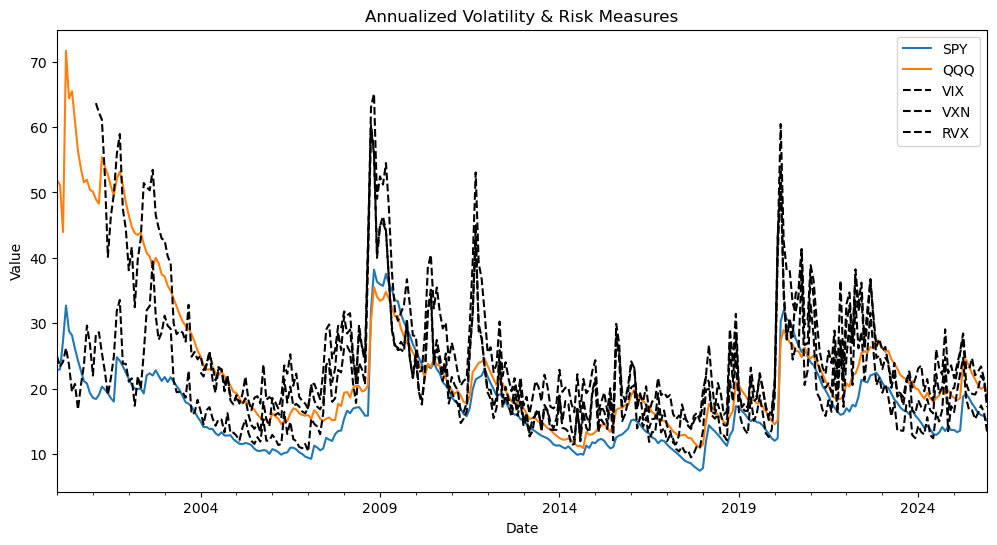

In [13]:
from matplotlib import pyplot as plt

annual_vol_monthly  = (weekly_returns.ewm(halflife=0.5*52).std() * np.sqrt(52))[['SPY', 'QQQ']].resample('M').last() * 100 # annualized volatility
risk_monthly = risk_measures.resample('M').last()
ax = annual_vol_monthly.plot(figsize=(12,6), title="Annualized Volatility & Risk Measures")
risk_monthly.plot(ax=ax, style='--', color='black')  # dashed black line for risk measure
plt.ylabel("Value")
plt.show()

In [40]:
pd.read_parquet(os.path.join(root, "data/expected_returns.parquet"))#.resample('M').last().iloc[190:].plot()

,ETHA,IBIT,IEF,IWM,MINT,QQQ,SPY,TLT,TQQQ,UPRO,UWM
Date,,,,,,,,,,,
2000-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30,NaN,NaN,0.012248,0.092939,0.025395,0.179513,0.138781,-0.005144,0.320885,0.250811,0.095047
2025-12-07,NaN,NaN,0.011972,0.094135,0.025588,0.181081,0.139452,-0.006647,0.325633,0.252947,0.097277
2025-12-14,NaN,NaN,0.011962,0.092246,0.025639,0.176681,0.136085,-0.006666,0.312383,0.242690,0.093524


<Axes: xlabel='Date'>

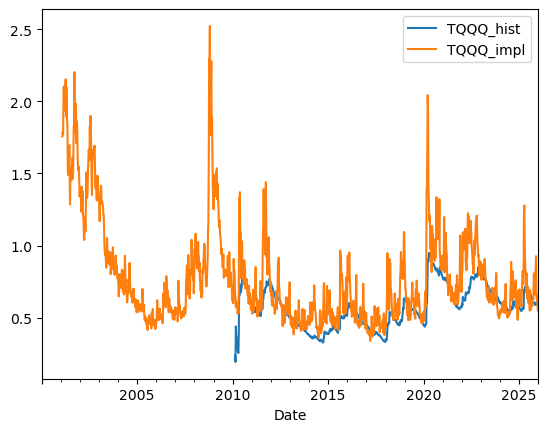

In [41]:
pd.read_parquet(os.path.join(root, "data/expected_volatility.parquet")).filter(regex='TQQQ').plot()

In [42]:
pd.read_parquet(os.path.join(root, "data/correlation.parquet"))

ETHA      IBIT       IEF       IWM      MINT       QQQ  \
Date                                                                          
2000-01-16 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
           SPY        NaN       NaN       NaN       NaN       NaN  1.000000   
2000-01-23 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
           SPY        NaN       NaN       NaN       NaN       NaN -0.219869   
2000-01-30 QQQ        NaN       NaN       NaN       NaN       NaN  1.000000   
...                   ...       ...       ...       ...       ...       ...   
2025-12-28 SPY   0.399002  0.250015  0.000134  0.848072  0.333991  0.937701   
           TLT   0.079970 -0.045886  0.921026  0.012920  0.078217  0.023544   
           TQQQ  0.433756  0.242611  0.015619  0.742197  0.279233  0.997520   
           UPRO  0.415496  0.250792  0.005976  0.850763  0.365391  0.931198   
           UWM   0.487764  0.396213  0.030353  0.999099  0.305619  0.733111   

                      SPY       TLT      TQQQ      UPRO       UWM  
Date                                                               
2000-01-16 QQQ   1.000000       NaN       NaN       NaN       NaN  
           SPY   1.000000       NaN       NaN       NaN       NaN  
2000-01-23 QQQ  -0.219869       NaN       NaN       NaN       NaN  
           SPY   1.000000       NaN       NaN       NaN       NaN  
2000-01-30 QQQ   0.734337       NaN       NaN       NaN       NaN  
...                   ...       ...       ...       ...       ...  
2025-12-28 SPY   1.000000  0.002436  0.940670  0.997314  0.847856  
           TLT   0.002436  1.000000  0.029447  0.009434  0.012454  
           TQQQ  0.940670  0.029447  1.000000  0.938396  0.742544  
           UPRO  0.997314  0.009434  0.938396  1.000000  0.853107  
           UWM   0.847856  0.012454  0.742544  0.853107  1.000000  

[10178 rows x 11 columns]

## Daily Job Setup

To run this daily automatically, create a separate Python script and schedule it with Task Scheduler (Windows) or cron (Linux/Mac).

### Option 1: Create `update_daily_prices.py`
Save this as a standalone script in the project root and schedule it to run daily at market close (4:00 PM ET).

### Option 2: Windows Task Scheduler
- Create a task that runs: `python backtest/backtest_notebooks/update_daily_prices.py`
- Schedule it for 4:30 PM daily
- Set working directory to project root

### Option 3: Linux/Mac cron
Add to crontab: `30 16 * * * cd /path/to/auto-ibkr && python backtest/update_daily_prices.py`